In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.special import softmax
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

/home/gurro/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', *, sep: 'str | None | lib.NoDefault' = <no_default>, delimiter: 'str | None | lib.NoDefault' = None, header: "int | Sequence[int] | None | Literal['infer']" = 'infer', names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>, index_col: 'IndexLabel | Literal[False] | None' = None, usecols=None, squeeze: 'bool | None' = None, prefix: 'str | lib.NoDefault' = <no_default>, mangle_dupe_cols: 'bool' = True, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters=None, true_values=None, false_values=None, skipinitialspace: 'bool' = False, skiprows=None, skipfooter: 'int' = 0, nrows: 'int | None' = None, na_values=None, keep_default_na: 'bool' = True, na_filter: 'bool' = True, verbose: 'bool' = False, skip_blank_lines: 'bool' = True, parse_dates=None, infer_datetime_format: 'bool' = False, keep_date_col: 'bool' = F

In [17]:
# Importazione dati

# PM10
dataset = pd.read_csv('../bayesmix/resources/datasets/ts.csv', header=None)
dataset_plot = pd.read_csv('../bayesmix/resources/datasets/ts_mean.csv', header=None)
print(dataset.shape)
print(dataset_plot.shape)
T = dataset.shape[1]

# Coordinate
coords_file = pd.read_csv('../bayesmix/resources/datasets/coord.csv', header=None)
print(coords_file.shape)
coords_file.head()

(112, 52)
(112, 52)
(112, 2)


,0,1
0,44.792231,10.331664
1,44.786999,10.332919
2,44.658309,10.285714
3,44.781024,10.349448
4,44.697300,10.401127


In [19]:
y = np.array(dataset)
y_plot = np.array(dataset_plot)
# y_i_t (rows -> localities; columns->weeks)
coords = np.array(coords_file) 

In [20]:
# Functions for time series 

def covf(v, tau): # v is a vector
    # Covariance function with time lag tau
    cov = 0
    # check over tau...
    for i in range(tau, len(v)):
        cov += (v[i] * v[i-tau])
    return (cov / len(v)-tau)


def avg_covf(vs, tau): # vs is a matrix
    # Average sample mean of covariance functions 
    # with time lag tau of all the series
    avg_cov = 0
    # check over tau...
    n = vs.shape[0] 
    for i in range(0, n): # da 0 ad n-1
        avg_cov += covf(np.array(vs[i]),tau)

    return (avg_cov / n)


In [21]:
def sample_nnig_post(clusdata, rho_0, lam, alpha, beta): 
    
    n = clusdata.shape[0] 
    T = clusdata.shape[1] 
    # clusdata is a matrix n*T
    
    A = n * (T-1) * avg_covf(clusdata[:, 0:(T - 1)],0) + lam
    B = n * (T-2) * avg_covf(clusdata[:, 0:(T - 1)],1) + lam*rho_0
    C = n * T * avg_covf(clusdata,0) + lam*(rho_0**2) 
    
    # Posterior parameters for sampling from the Normal (Rho (k+1))
    rho_post = B / A
    lam_post = A
    
    # Posterior parameters for sampling from the Inverse-Gamma (Sigma_2_h (k+1))
    alpha_post = alpha + (n * T)/2
    beta_post = beta + 0.5*( C - (B**2)/A )
    
    # Update Sigma_2_h (k+1)
    sig_2_new = tfd.InverseGamma(alpha_post, beta_post).sample()
    
    # Update Rho_h (k+1)
    rho_new = tfd.Normal(rho_post, np.sqrt(sig_2_new)/lam_post).sample() 
    #print(rho_new)
    
    return rho_new, sig_2_new


def marginal_nnig(y, rho_0, lam, alpha, beta):
    
    n = 1 # In questo caso
    T = len(y)
    
    A =  (T-1) * covf(y[0:(T - 1)],0) + lam
    B =  (T-2) * covf(y[0:(T - 1)],1) + lam * rho_0
    C =  T * covf(y,0) + lam*(rho_0**2)
    
    coeff = math.gamma(alpha + T/2) / \
            ( math.gamma(alpha) * (math.pi*2*alpha)**(T/2) * ( ((beta**T)*A)/((alpha**T)*lam) )**(0.5) )
    
    res = ( 1 + 1/(2*alpha)*( (alpha/beta)*(C - B**2/A) ) )**(-T/2 -alpha)
    
    return np.log( coeff*res )

In [22]:
#####################
### NEAL - STEP 1 ###
#####################
def sample_clus_allocs(y, clus_allocs, coords, rho_h, sig_2_h, M, a):
    
    T = y.shape[1]
    # clus_allocs = vector of labels of observation i: c_i
    # Unique values are stored in:
        # rho_h: vector of Rhos of the clusters labelled by c_i
        # sig_h: vector of Sigmas of the clusters labelled by c_i
    # M, a: parameters for the computation of the weights 
        # ------------> These two are to be decided <------------
    
    #_, n_by_clus=np.unique(clus_allocs,return_counts=True)
    # I don't care abut the unique values but i save only
    # the number of times the unique value appears.
    # n_by_clus = vector saying how many obs there are in label c_i
    
    for i in range(y.shape[0]):

        _, n_by_clus=np.unique(clus_allocs,return_counts=True)
                
        c_i=clus_allocs[i]
        n_by_clus[c_i] -= 1
        
        # Check if it was a singleton --> i have to delete it
        if n_by_clus[c_i]==0:
            n_by_clus = np.delete(n_by_clus,c_i) # Vettore delle cardinalità degli S_h^(-i)
            rho_h = np.delete(rho_h,c_i)   
            sig_2_h = np.delete(sig_2_h,c_i)    
            clus_allocs[clus_allocs>c_i]-=1 
            # Decreasing the labels greater than c_i in order to have labels in sequence
        
        K = len(n_by_clus)
        
        log_probs = np.zeros(K+1)
        
        # Probability of sitting in a table already existing:
        near_clus = np.ones(K) # variabili flag, se trovo una località troppo lontana (>a) diventerà zero
        
        x_i, y_i = coords[i][0], coords[i][1]
        # Cycling to check the distancies for each cluster
        for j in range(y.shape[0]):
            if ( not( near_clus.any() ) ):
                break
            else:
                if( j!=i ): 
                    if( near_clus[ clus_allocs[j] ] ):
                        x_j, y_j = coords[j][0], coords[j][1]
                        if( np.sqrt( (x_i-x_j)**2 + (y_i-y_j)**2 ) > a ):
                            near_clus[ clus_allocs[j] ] = 0
                        
        
        for k in range(0, K): 
            if(near_clus[k]):
                loc = np.zeros(T)
                diag = np.repeat(1 + rho_h[k]**2,T)
                diag[T-1] = 1
                inf_diag = sup_diag = np.repeat(-rho_h[k], T-1)
                H = np.diag(diag, 0) + np.diag(inf_diag, -1) + np.diag(sup_diag, 1)
                Sigma_inv = H / sig_2_h[k]                
                Sigma = np.linalg.inv(Sigma_inv)
                
                E,V = np.linalg.eigh(Sigma)                
                scale = np.linalg.cholesky(Sigma) #Sigma_inv
                
                log_probs[k] = np.log(n_by_clus[k])
                lik = tfd.MultivariateNormalTriL(loc, scale)
                log_probs[k] += lik.log_prob(y[i])  
            else:
                log_probs[k] = float('-inf')
        
        # Probability of sitting in a new table:
        log_probs[K] = np.log(M)
        marg = marginal_nnig(y[i], rho_0, lam, alpha, beta)
        log_probs[K] += marg 
        
        # Sampling a new label
        h_new = tfd.Categorical(probs=softmax(log_probs)).sample()  
                
        clus_allocs[i] = h_new
        
        if h_new == K:             
            # Sampling unique values -> i need to add them to the others
            # and also update n_by_clus
            # Faccio direttamente dalla prior
            rho_new = tfd.Normal(loc=rho_first, scale=sig_2_first/lam).sample(3)
            sig_2_new = tfd.InverseGamma(alpha, beta).sample(3)
            
            rho_h = np.concatenate([rho_h,rho_new])
            sig_2_h = np.concatenate([sig_2_h,sig_2_new])
            n_by_clus = np.concatenate([n_by_clus,[1]])
        else:
            n_by_clus[h_new] +=1
            
    return clus_allocs, rho_h, sig_2_h
 
#####################
### NEAL - STEP 2 ###
#####################

def sample_clus_params(y, clus_allocs, rho_0, lam, alpha, beta): # Anche qui ovviamente rivedi parametri
    nclus = len(np.unique(clus_allocs)) # K
    # How many unique values in the cluster allocations
    
    clus_labels=np.unique(clus_allocs) 
    # Vector where in position h i have label c
    
    rho_out=np.zeros(nclus)
    sig_2_out=np.zeros(nclus)
    
    for h,clus_id in enumerate(clus_labels): 
        tmp = sample_nnig_post(y[clus_allocs == clus_id], rho_0, lam, alpha, beta)
        rho_out[h]=tmp[0]
        sig_2_out[h]=tmp[1]
        
    return rho_out, sig_2_out


In [23]:
def run_one_gibbs(y, clus_allocs, coords, rho_h, sig_2_h, M, a):
        
    #####################
    ### NEAL - STEP 1 ###
    #####################
    
    clus_allocs, rho_h, sig_2_h = sample_clus_allocs(y, clus_allocs, coords, rho_h, sig_2_h, M, a)
    
    #####################
    ### NEAL - STEP 2 ###
    #####################
    
    rho_h, sig_2_h = sample_clus_params(y, clus_allocs, rho_0, lam, alpha, beta)
        
    return clus_allocs, rho_h, sig_2_h

In [26]:
## Fixed parameters
rho_0 = 0.4807468
lam = 13625.29
alpha = 7.690926
beta = 1257.956

## Initial values
rho_first = rho_0 # media campionaria dei rho
sig_2_first = 100

# sPPM parameters
a = 2 
M = 0.05 # Consigliato da paper sPPM caso C2 

data = y
data_plot = y_plot
n = data.shape[0]

n_clus_init = 3

clus_allocs = np.random.choice(np.arange(n_clus_init), size=y.shape[0])

rho_h = tfd.Normal(loc=rho_first, scale=sig_2_first/lam).sample(n_clus_init)
sig_2_h = tfd.InverseGamma(alpha, beta).sample(n_clus_init)

In [27]:
niter = 120
nburn = 20

#clus_chain = []
rho_chain = []
sig_2_chain = []
clus_chain = np.zeros((niter-nburn, n), dtype=int)

In [28]:
#%%time

# MCMC #
for i in range(niter):
    
    print("\r{0} / {1}".format(i+1, niter), flush=True, end=" ")

    clus_allocs, rho_h, sig_2_h = run_one_gibbs(y, clus_allocs, coords, rho_h, sig_2_h, M, a)
    #print(i)
    #print("Cluster allocations: ")
    #print(clus_allocs)
    #print("Rho_h: ")
    #print(rho_h)
    #print("Sigma_2_h: ")
    #print(sig_2_h)
    #print("__________________________________________________________________________________________")
    
    if i >= nburn:
        #clus_chain.append(clus_allocs)
        clus_chain[i-nburn] = clus_allocs
        rho_chain.append(rho_h)
        sig_2_chain.append(sig_2_h)

1 / 120 

/home/gurro/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/numpy/numpy_math.py:686: RuntimeWarning: divide by zero encountered in log
  lambda x, name=None: np.log(_convert_to_tensor(x)))


120 / 120 

In [145]:
# Salvataggio file

pd.DataFrame(clus_chain).to_csv(f'clus_chain_M_{M}_a_{int(a)}.csv')

In [146]:
print(clus_chain)

[[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 ...
 [1 1 1 ... 1 2 2]
 [1 1 1 ... 1 1 0]
 [1 2 2 ... 1 2 0]]


In [147]:
#print(rho_chain)

In [148]:
#print(sig_2_chain)

In [149]:
niter

120

In [150]:
nburn

20

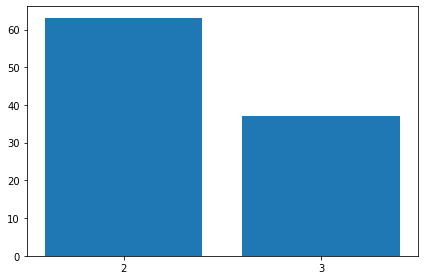

In [162]:
# distribution of the number of cluster
nclus_chain = np.zeros((niter-nburn), dtype=int)
for i in range(niter-nburn):
    nclus_chain[i] = np.max(clus_chain[i]) + 1
x_graph, y_graph = np.unique(nclus_chain, return_counts=True)
plt.bar(x_graph, y_graph)
plt.xticks(x_graph)
plt.show()

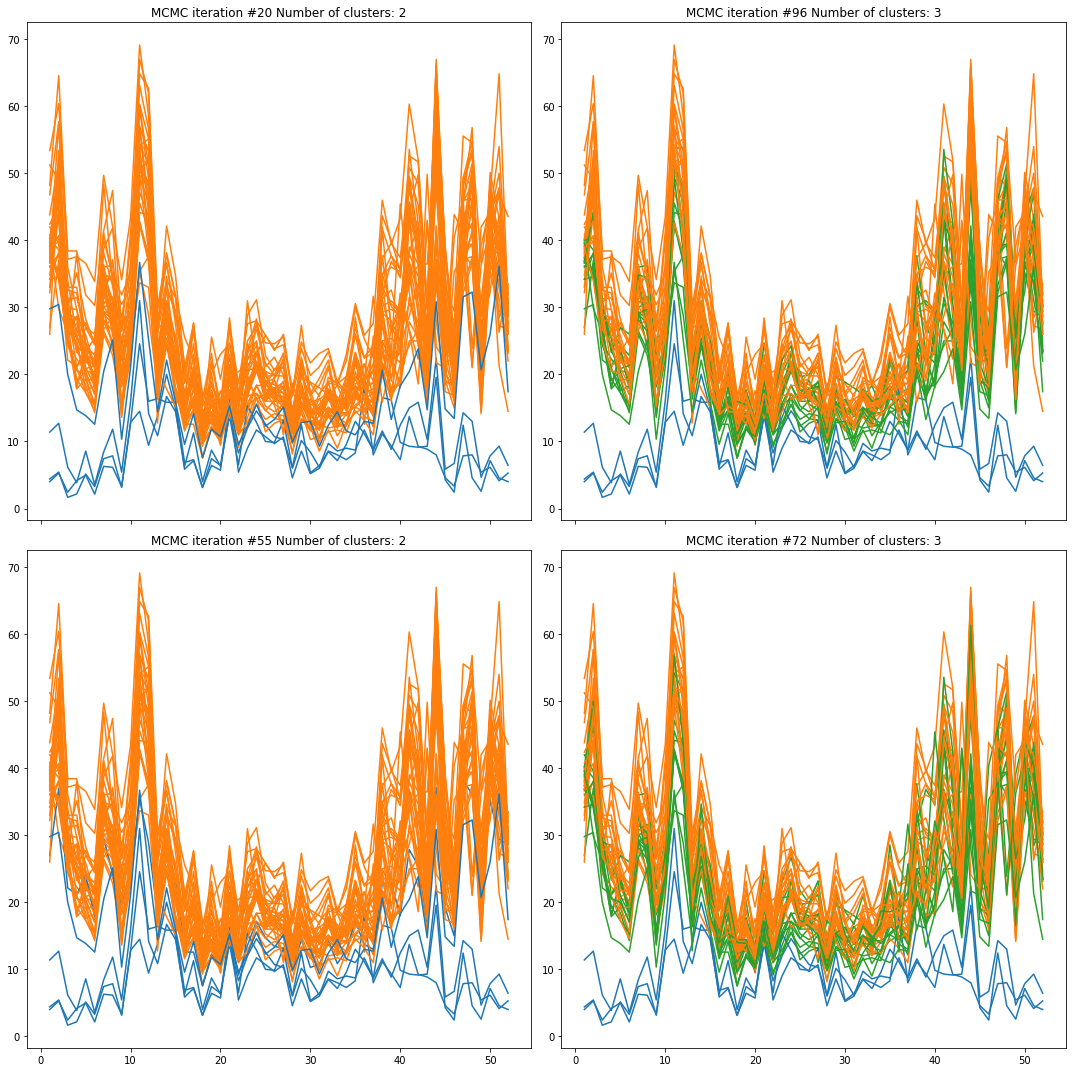

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

weeks = np.linspace(1, y.shape[1], 52)
list_scode = list(set(dataset.iloc[:,0]))
checks = 4 # Se lo volete provare mettete un numero pari grazie
clus_indeces = np.random.choice(np.arange(nclus_chain.shape[0]), size=checks)

figs, axs = plt.subplots(int(checks/2), 2, sharex=True, figsize=(15, 15))

for j in range(checks):

    clus_index = clus_indeces[j]
    palette = list(sns.color_palette(n_colors=len(np.unique(clus_chain[clus_index]))).as_hex())
    col_index = clus_chain[clus_index] # Il colore sarà indicato dalla label del cluster
    
    labels = []
    for i in range(len(np.unique(col_index))):
        labels.append("Cluster " + str(i+1))
    
    for i, col in enumerate(list_scode):
        axs[int(j/2), j%2].plot(weeks, data_plot[i], color=palette[int(col_index[i])], label=labels[int(col_index[i])])
        
    axs[int(j/2), j%2].set_title("MCMC iteration #" + str(clus_index) + \
                                 " Number of clusters: " + str(nclus_chain[clus_index]))

plt.savefig('sample.png')
plt.show()


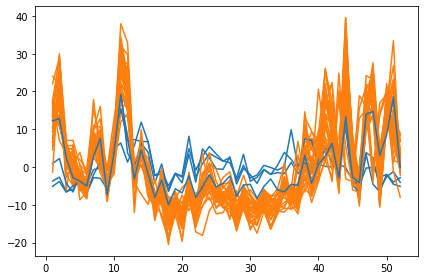

In [164]:
# Visualizing only one
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

clus_index = 0
palette = list(sns.color_palette(n_colors=len(np.unique(clus_chain[clus_index]))).as_hex())
col_index = clus_chain[clus_index] # Il colore sarà indicato dalla label del cluster
list_scode = list(set(dataset_plot.iloc[:,0]))

labels = []
for i in range(len(np.unique(col_index))):
    labels.append("Cluster " + str(i+1))

weeks = np.linspace(1, y.shape[1], 52)

#plt.rcParams["figure.figsize"] = [8.5, 6]
plt.rcParams["figure.autolayout"] = True
for i, col in enumerate(list_scode):
    plt.plot(weeks, data[i], color=palette[int(col_index[i])], label=labels[int(col_index[i])])

#plt.legend(labels)
plt.show()

In [20]:
df33 = pd.read_csv(f'clus_chain_M_{M}_a_{int(a)}.csv', delimiter=',')


In [21]:
np.array(df33)

array([[ 0,  0,  0, ...,  0,  1,  2],
       [ 1,  1,  0, ...,  0,  0,  2],
       [ 2,  0,  1, ...,  0,  1,  2],
       ...,
       [47,  2,  1, ...,  1,  1,  4],
       [48,  2,  1, ...,  3,  1,  4],
       [49,  1,  1, ...,  2,  1,  4]], dtype=int64)

In [22]:
# Lettura file salvati Sofia
param=[[0.01,12.85],[0.1,12.85],[1,12.85],[10,12.85],[1,12.85],[1,2*12.85],[1,3*12.85],[1,4*12.85]]

clus_chain_list = []

for i in range(len(param)):
    df = pd.read_csv(f'clus_chains/clus_chain[{param[i][0]}, {param[i][1]}].csv', delimiter=',')
    clus_chain_list.append(np.array(df.iloc[:,1:df.shape[1]]))
    
#clus_chain_list

In [23]:
clus_chain_list

[array([[0, 1, 0, ..., 1, 3, 4],
        [0, 1, 0, ..., 1, 3, 4],
        [0, 1, 0, ..., 1, 3, 4],
        ...,
        [0, 1, 0, ..., 1, 3, 6],
        [0, 1, 0, ..., 1, 3, 6],
        [0, 1, 0, ..., 1, 3, 6]], dtype=int64),
 array([[4, 3, 0, ..., 3, 5, 2],
        [0, 3, 0, ..., 3, 5, 2],
        [0, 3, 0, ..., 3, 5, 2],
        ...,
        [0, 2, 3, ..., 2, 4, 5],
        [0, 2, 0, ..., 2, 4, 5],
        [0, 2, 0, ..., 2, 4, 5]], dtype=int64),
 array([[1, 2, 1, ..., 2, 0, 3],
        [1, 2, 1, ..., 2, 0, 3],
        [1, 2, 1, ..., 2, 0, 3],
        ...,
        [1, 2, 1, ..., 2, 0, 3],
        [5, 2, 1, ..., 2, 0, 3],
        [1, 2, 1, ..., 2, 0, 3]], dtype=int64),
 array([[1, 0, 1, ..., 0, 3, 5],
        [1, 0, 1, ..., 0, 3, 5],
        [1, 0, 1, ..., 0, 3, 5],
        ...,
        [1, 4, 5, ..., 4, 3, 2],
        [5, 4, 5, ..., 4, 3, 2],
        [5, 4, 5, ..., 4, 3, 2]], dtype=int64),
 array([[1, 2, 1, ..., 2, 0, 3],
        [1, 2, 1, ..., 2, 0, 3],
        [1, 2, 1, ..., 2, 0, 3

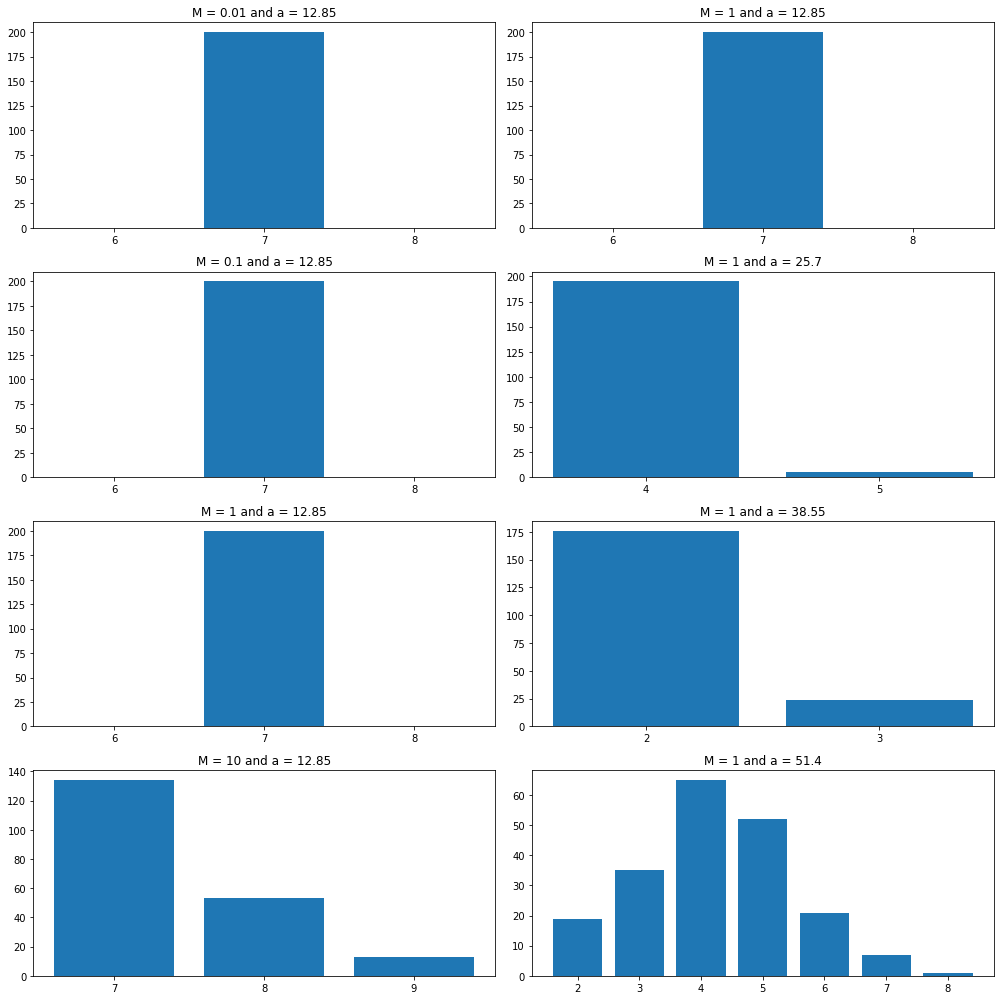

In [26]:
# Barplot al variare di a ed M
# I file sono contenuti nella cartella 'clus_chains'
n_row=4

fig, axs = plt.subplots(n_row, 2,figsize = (14,14))

for k in range(2*n_row):
    
    niter_saved = clus_chain_list[k].shape[0]
    
    if k<n_row:
        nclus_chain = np.zeros(niter_saved, dtype=int)
        for i in range(niter_saved):
            nclus_chain[i] = np.max(clus_chain_list[k][i]) + 1
        x, y = np.unique(nclus_chain, return_counts=True)

        if(len(x)==1):
            x = [x[0]-1, x[0], x[0]+1]
            y = [0, y[0], 0]
            
        axs[k,0].bar(x, y)
        axs[k,0].set_xticks(x)
        axs[k,0].set_title('M = '+str(param[k][0])+' and a = '+str(param[k][1]))
        
    else:
        nclus_chain = np.zeros(niter_saved, dtype=int)
        for i in range(niter_saved):
            nclus_chain[i] = np.max(clus_chain_list[k][i]) + 1
        x, y = np.unique(nclus_chain, return_counts=True)

        if(len(x)==1):
            x = [x[0]-1, x[0], x[0]+1]
            y = [0, y[0], 0]
            
        axs[k%n_row,1].bar(x, y)
        axs[k%n_row,1].set_xticks(x)
        axs[k%n_row,1].set_title('M = '+str(param[k][0])+' and a = '+str(param[k][1]))

In [27]:
test = np.arange(7)+1
test

array([1, 2, 3, 4, 5, 6, 7])

Da qui in poi sarebbe utile inserire le funzioni della Challenge 1 -esercizio 2- per fare un pò di inferenza, trovare la catena che produce il cluster migliore con la Binder's Loss function e calcolare i valori unici all'interno dei cluster (questa volta, a posteriori, non ci ho pensato su troppo e visto che non è una mistura di normali nel nostro caso potrebbe essere più complicato). Sotto ho già riportato le funzioni che girano, le altre non sono ancora state copiate. Può essere utile, magari, valutare la Binder Loss su più giri di MCMC con parametri diversi per fare cross-validation di M ed a.

In [28]:
def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    c_chain = np.vstack(clus_alloc_chain)
    n_clus=5

    # c_chain.shape[1] sarà N = # Osservazioni 
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]): # Si può partire da i+1
            if(i==j):
                out[i,j] = 1
            else:
                # Proporzione del numero di volte in cui viene 
                # assegnato allo stesso cluster nelle run di MC 
                count=0
                for m in range(c_chain.shape[0]):
                    if( c_chain[m,i]==c_chain[m,j] ): 
                        count+=1

                out[i,j] = count/c_chain.shape[0]
                out[j,i] = out[i,j]
                
    return out

In [ ]:
# Binder Loss Function
def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    # TODO: compute the losses!
    for m in range(c_chain.shape[0]):
        for i in range(c_chain.shape[1]):
            for j in range(c_chain.shape[1]): # Si può partire da i+1
                if(i!=j):
                    losses[m] += ( int( c_chain[m,i] == c_chain[m,j] ) - psm[i,j] )**2
   
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]

In [ ]:
psm = get_psm(clus_chain)

In [ ]:
best_clus = minbinder_sample(clus_allocs, psm)

In [ ]:
best_clus